In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# These functions deal with the .csv files of the period
# data from the LoggerPro software. The data is from a
# photogate.

def averageTFind(fileName):
    """
    fileName: .csv from photogate on a pendulum (string)
    
    returns: average period (float)
    """
    holderObject = np.genfromtxt(fileName, delimiter=",", skip_header=1)
    numberPeriods = (len(holderObject[:,0]) - 1) // 4
    totalTime = holderObject[numberPeriods * 4, 0] - holderObject[0,0]
    avgPeriod = totalTime / numberPeriods
    return avgPeriod

def averageOmegFind(fileName):
    """
    fileName: .csv from photogate on a pendulum (string)
    
    returns: average omega (float)
    """
    holderObject = np.genfromtxt(fileName, delimiter=",", skip_header=1)
    numberPeriods = (len(holderObject[:,0]) - 1) // 4
    totalTime = holderObject[numberPeriods * 4, 0] - holderObject[0,0]
    avgPeriod = totalTime / numberPeriods
    avgOmega = avgPeriod**(-1)*2*np.pi
    
    return avgOmega

def linFit(x, m, b):
    return m*x + b

def intersectTool(inputArray, spread_1="All", spread_2="All"):
    """
    inputArray: an Nx3 array of
                [offset, metal_period, wood_period]
    
    spread_1:   Has two options. Default is "All", which
                takes all points. Else it is an array [a,b]
                which will find the slope of the METAL best
                fit line for data entries a-b
    
    spread_2:   Has two options. Default is "All", which
                takes all points. Else it is an array [a,b]
                which will find the slope of the WOOD best
                fit line for data entries a-b
    ------
    returns: metalArray, woodArray
    
    [[materialM, materialM_stdDev],
     [materialB, materialB_stdDev]]
    """
    inputSize = len(inputArray)
    
    if spread_1=="All":
        metalArray = np.zeros([inputSize, 2])
        metalArray[:,0] = inputArray[:,0]
        metalArray[:,1] = inputArray[:,1]
    else:
        localSize = spread_1[1]-spread_1[0]+1
        currentPosition = spread_1[0]
        targetPosistion = spread_1[1]
        metalArray = np.zeros(localSize,2)
        while currentPosition <= targetPosition:
            metalArray[currentPosition] = np.array([inputArray[currentPosition,0],inputArray[currentPosition,1]])
            currentPosition = currentPosition + 1
    
    if spread_2=="All":
        woodArray = np.zeros([inputSize, 2])
        woodArray[:,0] = inputArray[:,0]
        woodArray[:,1] = inputArray[:,2]
    else:
        localSize = spread_2[1]-spread_2[0]+1
        currentPosition = spread_2[0]
        targetPosistion = spread_2[1]
        woodArray = np.zeros(localSize,2)
        while currentPosition <= targetPosition:
            woodArray[currentPosition] = np.array([inputArray[currentPosition,0],inputArray[currentPosition,2]])
            currentPosition = currentPosition + 1
    
    metalVars, metalCoeffs = curve_fit(linFit, metalArray[:,0], metalArray[:,1])
    woodVars, woodCoeffs = curve_fit(linFit, woodArray[:,0], woodArray[:,1])
    
    metalM, metalM_stdDev = metalVars[0], np.sqrt(metalCoeffs[0,0])
    metalB, metalB_stdDev = metalVars[1], np.sqrt(metalCoeffs[1,1])
    
    woodM, woodM_stdDev =  woodVars[0], np.sqrt(woodCoeffs[0,0])
    woodB, woodB_stdDev = woodVars[1], np.sqrt(woodCoeffs[1,1])
    
    return np.array([[metalM, metalM_stdDev],[metalB, metalB_stdDev]]), np.array([[woodM, woodM_stdDev],[woodB, woodB_stdDev]])

In [3]:
# creates an array called roughPass, that contains an Nx3 array of
# [collar distance, omega_metal, omega_wood]

offsets = np.array([200, 225, 250, 275, 300, 325, 350, 375, 400])
N = len(offsets)
roughPassOmega = np.zeros([N,3])
n = 0

while n < N:
    roughPassOmega[n] = np.array([offsets[n], averageOmegFind("../data/Metal"+str(offsets[n])+"mm.csv"), averageOmegFind("../data/Wood"+str(offsets[n])+"mm.csv")])
    n = n + 1

roughPassPeriod = np.zeros([N,3])
n = 0
while n < N:
    roughPassPeriod[n] = np.array([offsets[n], averageTFind("../data/Metal"+str(offsets[n])+"mm.csv"), averageTFind("../data/Wood"+str(offsets[n])+"mm.csv")])
    n = n + 1

In [4]:
# creating data to plot best fit lines of period vs collar displacement

metalBestFit, woodBestFit = intersectTool(roughPassPeriod)

offsetDifference = offsets[-1] - offsets[0]

xData = np.linspace(offsets[0] - .05*offsetDifference, offsets[-1] + .05*offsetDifference, 2501)
metalY_data = linFit(xData, metalBestFit[0,0], metalBestFit[1,0])
woodY_data= linFit(xData, woodBestFit[0,0], woodBestFit[1,0])

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


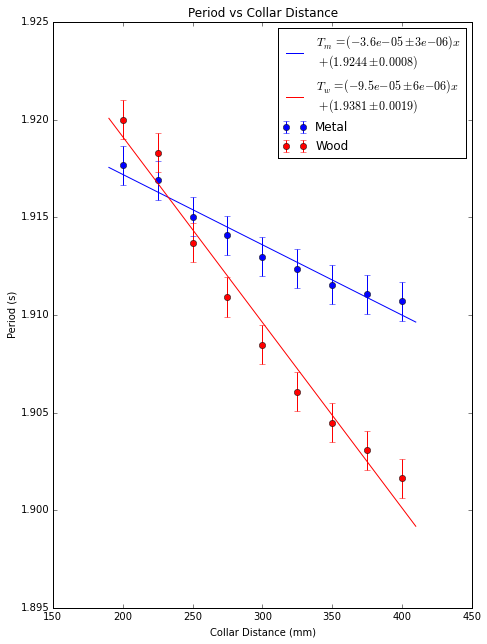

In [5]:
#plots wood period vs collar distance & metal period vs collar distance

periodError = .001 #This is empiracally determined

fig1 = plt.figure(figsize=(10))
plt.errorbar(roughPassPeriod[:,0], roughPassPeriod[:,1], yerr=periodError, fmt="bo ", label="Metal")
plt.errorbar(roughPassPeriod[:,0], roughPassPeriod[:,2], yerr=periodError, fmt="ro ", label="Wood")
plt.plot(xData, metalY_data, "b-", label="$T_m = ("+str(round(metalBestFit[0,0],6))+" \pm"+str(round(metalBestFit[0,1], 6))+")x$\n$+ ("+str(round(metalBestFit[1,0],4))+" \pm "\
         +str(round(metalBestFit[1,1], 4))+")$")
plt.plot(xData, woodY_data, "r-", label="$T_w = ("+str(round(woodBestFit[0,0],6))+" \pm"+str(round(woodBestFit[0,1], 6))+")x$\n$+ ("+str(round(woodBestFit[1,0],4))+" \pm "\
         +str(round(woodBestFit[1,1], 4))+")$")
plt.title("Period vs Collar Distance")
plt.ylabel("Period (s)")
plt.xlabel("Collar Distance (mm)")
plt.legend()

plt.savefig("../images/periodVsCollar.png")

In [6]:
roughEstimateT = (woodBestFit[1,0] - metalBestFit[1,0]) / (metalBestFit[0,0] - woodBestFit[0,0])
print("The rough estimate of the collar length associated with omega_naught is " + str(round(roughEstimateT, 2)) + "mm.\nThis is the point around which we will take more refined readings.")

The rough estimate of the collar length associated with omega_naught is 232.66mm.
This is the point around which we will take more refined readings.


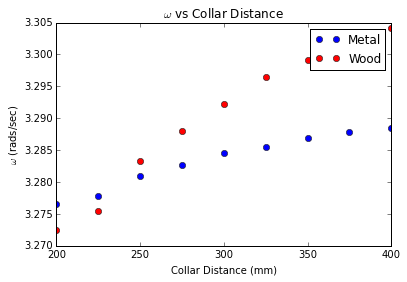

In [7]:
#plots wood omega vs collar distance & metal_omega vs collar distance

plt.plot(roughPassOmega[:,0], roughPassOmega[:,1], "bo ", label="Metal")
plt.plot(roughPassOmega[:,0], roughPassOmega[:,2], "ro ", label="Wood")
plt.title("$\omega$ vs Collar Distance")
plt.ylabel("$\omega$ (rads/sec)")
plt.xlabel("Collar Distance (mm)")
plt.legend()